In [1]:
# Data Wrangling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
#%matplotlib inline

# EDA
# from pandas_profiling import ProfileReport
# import dataprep.eda as dp 
# import platform
# path = "c:/Windows/Fonts/malgun.ttf"
# if platform.system() == 'Darwin':
#     rc('font', family='AppleGothic')
# elif platform.system() == 'Windows':
#     font_name = font_manager.FontProperties(fname=path).get_name()
#     rc('font', family=font_name)
# else:
#     print('Unknown system...')
# rc('axes', unicode_minus=False) 

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
#from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold

# Hyperparameter Optimization
# import optuna                                            
from sklearn import model_selection
from sklearn.model_selection import RandomizedSearchCV

# Modeling
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier                     
from sklearn.ensemble import AdaBoostClassifier         
from xgboost import XGBClassifier                       
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm, tqdm_notebook
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

from sklearn.metrics import make_scorer
from sklearn.metrics import log_loss

C:\Users\choij\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\choij\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\choij\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [4]:
num_train = pd.read_csv(os.path.abspath("../input")+'/feature_1round_third_train.csv')
num_test = pd.read_csv(os.path.abspath("../input")+'/feature_1round_third_test.csv')
#one_hot_train = pd.read_csv(os.path.abspath("../input")+f'/onehot_features_{time}.csv')
#one_hot_test = pd.read_csv(os.path.abspath("../input")+f'/onehot_features_te_{time}.csv')

y_target = pd.read_csv(os.path.abspath("../input")+'/y_train.csv').group

In [5]:
# categorical feature merge
#num_train = pd.concat([num_train,one_hot_train],axis=1)
#num_test = pd.concat([num_test,one_hot_test],axis=1)

In [6]:
test = pd.read_csv(os.path.abspath("../input")+'/X_test.csv', encoding='cp949')

In [7]:
num_train.shape, num_test.shape

((21587, 1061), (14380, 1061))

In [8]:
num_train.drop(columns=['30_weight_ratio'], inplace=True)
num_test.drop(columns=['30_weight_ratio'], inplace=True)

## 1. Selection

*shap*

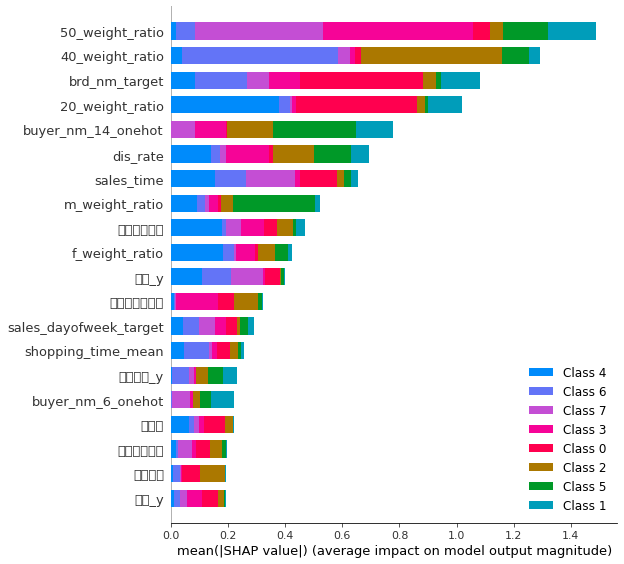

In [9]:
# Method: Using SHAP values 
import shap

# DF, based on which importance is checked
X_importance = num_test

# Explain model predictions using shap library:
model = LGBMClassifier(random_state=2020).fit(num_train, y_target)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

In [10]:
shap_sum = np.abs(shap_values).mean(axis=1)[1,:]
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
13,50_weight_ratio,0.168233
620,brd_nm_target,0.133484
1046,buyer_nm_14_onehot,0.131078
11,20_weight_ratio,0.121461
1038,buyer_nm_6_onehot,0.080021
...,...,...
569,month_c_8,0.0
570,month_c_9,0.0
571,month_c_10,0.0
572,month_c_11,0.0


In [11]:
# feature 중요도가 0 이상
SHAP_THRESHOLD = 0
features_selected = importance_df.query('shap_importance > @SHAP_THRESHOLD').column_name.tolist()

In [12]:
num_train = num_train[features_selected]
num_test = num_test[features_selected]
print(num_train.shape, num_test.shape)

(21587, 499) (14380, 499)


(21587, 499) (14380, 499)

In [13]:
train_selected = num_train
test_selected = num_test

*통계기반 selection*

In [14]:
'''
# catboost모델을 사용하여 RF 기반 selection

selector = SelectFromModel(CatBoostClassifier(random_state=2020), threshold=None)

train_selected = selector.fit_transform(num_train, y_target)
test_selected = selector.transform(num_test)

train_selected.shape, test_selected.shape
'''

'\n# catboost모델을 사용하여 RF 기반 selection\n\nselector = SelectFromModel(CatBoostClassifier(random_state=2020), threshold=None)\n\ntrain_selected = selector.fit_transform(num_train, y_target)\ntest_selected = selector.transform(num_test)\n\ntrain_selected.shape, test_selected.shape\n'

*select feature save*

In [16]:
#train_selected = np.load(os.path.abspath("../input")+f'/feature_select_nogajungchi_{time}.npy')
#test_selected =  np.load(os.path.abspath("../input")+f'/feature_te_select_nogajungchi_{time}.npy')

In [17]:
train_selected.shape, test_selected.shape

((21587, 499), (14380, 499))

In [19]:
train_selected.to_csv("1round_third_select_499_train.csv",index = False,encoding = 'utf-8')
test_selected.to_csv("1round_third_select_499_test.csv",index = False,encoding = 'utf-8')

In [21]:
clf = LGBMClassifier(random_state = 1000)

In [23]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, train_selected, y_target, scoring='neg_log_loss', cv=5)
print('교차 검증별 정확도:', np.round(scores, 4))
print('평균 검증 정확도:', np.round(np.mean(scores), 4))
print('log_loss:', np.mean(scores))

교차 검증별 정확도: [-1.5148 -1.5239 -1.5115 -1.487  -1.5152]
평균 검증 정확도: -1.5105
log_loss: -1.5104820061323916


In [24]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000)
str_scores = cross_val_score(clf, train_selected, y_target, scoring='neg_log_loss', cv=cv)
print('교차 검증별 정확도:', np.round(str_scores, 4))
print('평균 검증 정확도:', np.round(np.mean(str_scores), 4))
print('log_loss:', np.mean(str_scores))

교차 검증별 정확도: [-1.5126 -1.5156 -1.537  -1.5038 -1.527 ]
평균 검증 정확도: -1.5192
log_loss: -1.5191962286817686


***

## 2. Modeling

In [14]:
# 학습데이터 70%, 평가데이터 30%로 데이터 분할
X_train, X_dev, y_train, y_dev = train_test_split(train_selected, y_target, test_size=0.3, random_state=2020)

### *Catboost*

In [15]:
X_train.shape, X_dev.shape, y_train.shape

((15110, 499), (6477, 499), (15110,))

In [ ]:
cat_model=CatBoostClassifier(random_state=2020,iterations=18000,depth=3,bootstrap_type ='Bayesian') # learning rate = 0.007902
cat_model.fit(X_train,y_train)

Learning rate set to 0.007902
0:	learn: 2.0719221	total: 230ms	remaining: 1h 9m 4s
1:	learn: 2.0649299	total: 290ms	remaining: 43m 30s
2:	learn: 2.0582487	total: 366ms	remaining: 36m 35s
3:	learn: 2.0508367	total: 436ms	remaining: 32m 41s
4:	learn: 2.0449080	total: 495ms	remaining: 29m 41s
5:	learn: 2.0384340	total: 550ms	remaining: 27m 29s
6:	learn: 2.0318014	total: 607ms	remaining: 25m 59s
7:	learn: 2.0259409	total: 664ms	remaining: 24m 54s
8:	learn: 2.0201141	total: 716ms	remaining: 23m 51s
9:	learn: 2.0145720	total: 772ms	remaining: 23m 9s
10:	learn: 2.0090240	total: 829ms	remaining: 22m 36s
11:	learn: 2.0034411	total: 895ms	remaining: 22m 22s
12:	learn: 1.9978944	total: 957ms	remaining: 22m 4s
13:	learn: 1.9927553	total: 1.02s	remaining: 21m 52s
14:	learn: 1.9872612	total: 1.09s	remaining: 21m 45s
15:	learn: 1.9818818	total: 1.15s	remaining: 21m 34s
16:	learn: 1.9768359	total: 1.22s	remaining: 21m 28s
17:	learn: 1.9717963	total: 1.28s	remaining: 21m 21s
18:	learn: 1.9671822	total:

157:	learn: 1.6899253	total: 9.77s	remaining: 18m 23s
158:	learn: 1.6891385	total: 9.85s	remaining: 18m 24s
159:	learn: 1.6882735	total: 9.92s	remaining: 18m 25s
160:	learn: 1.6875794	total: 9.97s	remaining: 18m 24s
161:	learn: 1.6868274	total: 10s	remaining: 18m 23s
162:	learn: 1.6859190	total: 10.1s	remaining: 18m 23s
163:	learn: 1.6853118	total: 10.2s	remaining: 18m 23s
164:	learn: 1.6843228	total: 10.2s	remaining: 18m 23s
165:	learn: 1.6835820	total: 10.3s	remaining: 18m 23s
166:	learn: 1.6827813	total: 10.3s	remaining: 18m 23s
167:	learn: 1.6820256	total: 10.4s	remaining: 18m 23s
168:	learn: 1.6813099	total: 10.5s	remaining: 18m 22s
169:	learn: 1.6806756	total: 10.5s	remaining: 18m 22s
170:	learn: 1.6798667	total: 10.6s	remaining: 18m 22s
171:	learn: 1.6790959	total: 10.6s	remaining: 18m 22s
172:	learn: 1.6782752	total: 10.7s	remaining: 18m 21s
173:	learn: 1.6774427	total: 10.7s	remaining: 18m 21s
174:	learn: 1.6766411	total: 10.8s	remaining: 18m 21s
175:	learn: 1.6758222	total: 1

In [22]:
pred_cat = cat_model.predict_proba(X_dev)
log_loss(y_dev, pred_cat)

1.4518353501548178

In [28]:
# save cat model
import joblib

joblib.dump(cat_model, f'../model/cat_model_nogajungchi_{time}.pkl')

['../model/cat_model_nogajungchi_0609_1005.pkl']

In [21]:
# load cat model
# joblib.load('f'../model/cat_model_{time}.pkl')

CatBoostClassifier(random_state=2020,iterations=18000,depth=3,bootstrap_type ='Bayesian')  

---

## Submission

In [23]:
IDtest = test.custid.unique()

In [24]:
# submission
select_model = cat_model
pred = pd.DataFrame(select_model.predict_proba(test_selected))
pred.columns = ['F20','F30','F40','F50','M20','M30','M40','M50']
submissions = pd.concat([pd.Series(IDtest, name="ID"), pred] ,axis=1)
submissions

,ID,F20,F30,F40,F50,M20,M30,M40,M50
0,30001,0.167128,0.127825,0.048450,0.161191,0.117580,0.188142,0.014828,0.174857
1,30002,0.023033,0.094451,0.352094,0.022551,0.003464,0.048101,0.416684,0.039621
2,30003,0.807000,0.120425,0.015854,0.008013,0.017574,0.020088,0.004134,0.006911
3,30005,0.569638,0.138961,0.053942,0.035398,0.028294,0.094697,0.037761,0.041309
4,30007,0.867121,0.047035,0.013033,0.004223,0.040532,0.019846,0.004047,0.004164
...,...,...,...,...,...,...,...,...,...
14375,49988,0.031502,0.541581,0.037433,0.005436,0.012388,0.289934,0.075294,0.006433
14376,49990,0.448224,0.211002,0.114841,0.039442,0.028104,0.072178,0.037070,0.049138
14377,49992,0.305413,0.195783,0.082076,0.098873,0.082453,0.136854,0.038262,0.060287
14378,49993,0.082311,0.488562,0.197392,0.007409,0.010454,0.140257,0.071264,0.002351


In [25]:
fname = f'/submission_cat_nogajungchi_{time}.csv'
submissions.to_csv(os.path.abspath("../submission")+fname, index=False)
print(fname)

/submission_cat_nogajungchi_0609_1005.csv
